<a href="https://colab.research.google.com/github/mehrotrasan16/Keras-Deep-Learning/blob/02-horsesvhumans-VGG16-TransferLearning/A2_Q3_VGG16_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

# Loading and Preprocessing the Data

In [ ]:
(raw_data, raw_validation,raw_test), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)  

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteDO7YHT/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteDO7YHT/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [ ]:
print(raw_data,raw_validation,raw_test)

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)> <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)> <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


In [ ]:
get_label_name = metadata.features['label'].int2str

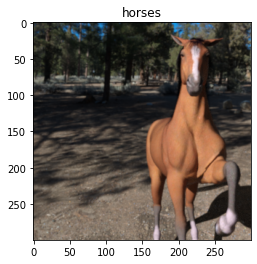

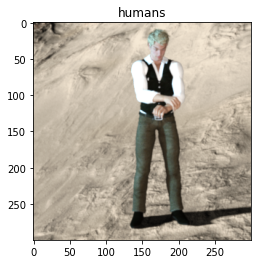

In [ ]:
for image,label in raw_data.shuffle(1024).take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [ ]:
IMG_SIZE=160

def format_example(image,label):
    image=tf.cast(image,tf.float32)
    #normalizing the values
    image=(image/127.5) - 1
    #scaling the image
    image=tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return image,label

In [ ]:
train = raw_data.map(format_example)
validation=raw_validation.map(format_example)
test=raw_test.map(format_example)

In [ ]:
validation,test

(<DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>,
 <DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>)

# Batching the Data"

In [ ]:
BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches=validation.batch(BATCH_SIZE)
test_batches=test.batch(BATCH_SIZE)

for image_batch,label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

# Loading the MobileNet Model

In [ ]:
IMG_SHAPE=(IMG_SIZE,IMG_SIZE,3)

base_model=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
feature_batch=base_model(image_batch)
print(feature_batch.shape)

58892288/58889256 [==============================] - 3s 0us/step
(32, 5, 5, 512)


In [ ]:
base_model.trainable=False

In [ ]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model=keras.Sequential([
                        base_model,
                        global_average_layer,
                        prediction_layer
])

In [ ]:
base_learning_rate=0.0001
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics='accuracy'
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## Initial Shallow Training

In [ ]:
checkpoint_filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [ ]:
initial_epochs=10
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
     26/Unknown - 1s 51ms/step - loss: 0.6991 - accuracy: 0.4672WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 94ms/step - loss: 0.6991 - accuracy: 0.4672 - val_loss: 0.6636 - val_accuracy: 0.6078
Epoch 2/10
25/26 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.4700WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 61ms/step - loss: 0.6779 - accuracy: 0.4672 - val_loss: 0.6551 - val_accuracy: 0.6078
Epoch 3/10
25/26 [===========================>..] - ETA: 0s - loss: 0.6621 - accuracy: 0.4650WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 63ms/step - loss: 0.6610 - accuracy: 0.4672 - val_loss: 0.6442 - val_accuracy: 0.6176
Epoch 4/10
25/26 [===========================>..] - ETA: 0s - loss: 0.6478 - accuracy: 0.4675WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 61ms/step - loss: 0.6465 - accuracy: 0.4672 - val_loss: 0.6338 - val_accuracy: 0.6176
Epoch 5/10
25/26 [===========================>..] - ETA: 0s - loss: 0.6322 - accuracy: 0.4625WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 62ms/step - loss: 0.6324 - accuracy: 0.4672 - val_loss: 0.6219 - val_accuracy: 0.6176
Epoch 6/10
25/26 [===========================>..] - ETA: 0s - loss: 0.6184 - accuracy: 0.4750WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 61ms/step - loss: 0.6189 - accuracy: 0.4720 - val_loss: 0.6118 - val_accuracy: 0.6176
Epoch 7/10
25/26 [===========================>..] - ETA: 0s - loss: 0.6059 - accuracy: 0.4800WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 62ms/step - loss: 0.6053 - accuracy: 0.4818 - val_loss: 0.6003 - val_accuracy: 0.6569
Epoch 8/10
25/26 [===========================>..] - ETA: 0s - loss: 0.5920 - accuracy: 0.5200WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 62ms/step - loss: 0.5918 - accuracy: 0.5268 - val_loss: 0.5867 - val_accuracy: 0.6765
Epoch 9/10
25/26 [===========================>..] - ETA: 0s - loss: 0.5790 - accuracy: 0.5462WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 62ms/step - loss: 0.5791 - accuracy: 0.5426 - val_loss: 0.5758 - val_accuracy: 0.6863
Epoch 10/10
25/26 [===========================>..] - ETA: 0s - loss: 0.5674 - accuracy: 0.5713WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 62ms/step - loss: 0.5667 - accuracy: 0.5706 - val_loss: 0.5639 - val_accuracy: 0.6961


In [ ]:
model.evaluate(test_batches)

4/4 [==============================] - 1s 140ms/step - loss: 0.5737 - accuracy: 0.6214


[0.5736774802207947, 0.6213592290878296]

4/4 - 0s - loss: 0.5639 - accuracy: 0.6961

Test accuracy: 0.6960784196853638


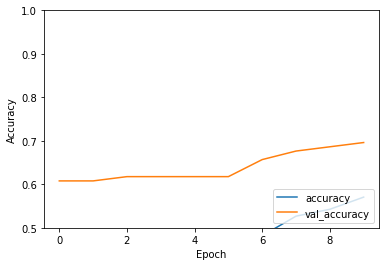

In [ ]:
#Evaluate the Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\nTest accuracy:', test_acc)

# Fine Tuning

In [ ]:
base_model.trainable=True

print('Number of layers in the base model: ',len(base_model.layers))

finetune_at=155

Number of layers in the base model:  19


In [ ]:
for layer in base_model.layers[:finetune_at]:
    layer.trainable=False

In [ ]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy']
              )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
fine_tuning_epochs=10
total_epochs=initial_epochs+fine_tuning_epochs

history_fine=model.fit(
train_batches,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=validation_batches
)

Epoch 10/20
26/26 [==============================] - 2s 68ms/step - loss: 0.5591 - accuracy: 0.5852 - val_loss: 0.5624 - val_accuracy: 0.6961
Epoch 11/20
26/26 [==============================] - 2s 62ms/step - loss: 0.5578 - accuracy: 0.5900 - val_loss: 0.5612 - val_accuracy: 0.7059
Epoch 12/20
26/26 [==============================] - 2s 61ms/step - loss: 0.5566 - accuracy: 0.5900 - val_loss: 0.5602 - val_accuracy: 0.7059
Epoch 13/20
26/26 [==============================] - 2s 60ms/step - loss: 0.5554 - accuracy: 0.5973 - val_loss: 0.5590 - val_accuracy: 0.7059
Epoch 14/20
26/26 [==============================] - 2s 61ms/step - loss: 0.5541 - accuracy: 0.6022 - val_loss: 0.5578 - val_accuracy: 0.7059
Epoch 15/20
26/26 [==============================] - 2s 60ms/step - loss: 0.5529 - accuracy: 0.6010 - val_loss: 0.5566 - val_accuracy: 0.7059
Epoch 16/20
26/26 [==============================] - 2s 61ms/step - loss: 0.5517 - accuracy: 0.6058 - val_loss: 0.5554 - val_accuracy: 0.7059
Epoch 

In [ ]:
model.evaluate(test_batches)

4/4 [==============================] - 0s 73ms/step - loss: 0.5608 - accuracy: 0.6796


[0.5607730746269226, 0.6796116232872009]

4/4 - 0s - loss: 0.5509 - accuracy: 0.7157

 Fine Tuned Test accuracy: 0.7156862616539001


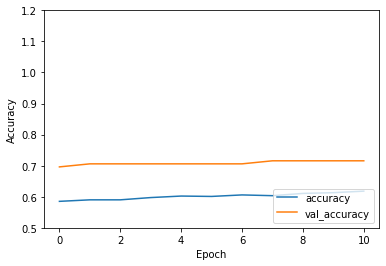

In [ ]:
#Evaluate the Model
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.2])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(validation_batches, verbose=2)
print('\n Fine Tuned Test accuracy:', test_acc)